# 데이터 로드 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
from glob import glob 
import os 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf '/content/drive/MyDrive/공유용/train_features.tar'

In [ ]:
csvs_dir = glob('/content/katl/*.bz2')
csvs_dir.sort()
csvs_dir = pd.DataFrame(csvs_dir,columns=['dir'])
csvs_name = list(csvs_dir['dir'].apply(lambda x : x.split('katl/')[-1].split('.csv')[0].split('_',maxsplit=1)[-1]))

In [32]:
def make_dir(dir,df):
  csv_dir = df[df['dir'].apply(lambda x : dir in x )].values[0][0]
  return csv_dir 

In [ ]:
for csv_name in tqdm(csvs_name):
  exec(f"{csv_name} = pd.read_csv(make_dir('{csv_name}',csvs_dir))")

# Baseline 

In [1]:
from pathlib import Path
from typing import Sequence, Tuple
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns 

## Get Data 
- 필요한 데이터는 Training features, Training labels , Submission format 

In [2]:
DATA_PATH = Path("../content/")

In [3]:
airport_directories = sorted(path for path in DATA_PATH.glob("k*"))
airport_directories

[PosixPath('../content/katl'),
 PosixPath('../content/kclt'),
 PosixPath('../content/kden'),
 PosixPath('../content/kdfw'),
 PosixPath('../content/kjfk'),
 PosixPath('../content/kmem'),
 PosixPath('../content/kmia'),
 PosixPath('../content/kord'),
 PosixPath('../content/kphx'),
 PosixPath('../content/ksea')]

10개의 공항 별로 폴더가 있음 

In [4]:
airport_directory = airport_directories[0]
data_files = list(airport_directory.glob("*"))
data_files

[PosixPath('../content/katl/katl_arrival_runway.csv.bz2'),
 PosixPath('../content/katl/katl_tfm_estimated_runway_arrival_time.csv.bz2'),
 PosixPath('../content/katl/katl_airport_config.csv.bz2'),
 PosixPath('../content/katl/katl_departure_runway.csv.bz2'),
 PosixPath('../content/katl/katl_etd.csv.bz2'),
 PosixPath('../content/katl/katl_first_position.csv.bz2'),
 PosixPath('../content/katl/katl_mfs_stand_arrival_time.csv.bz2'),
 PosixPath('../content/katl/katl_mfs_stand_departure_time.csv.bz2'),
 PosixPath('../content/katl/katl_mfs_runway_departure_time.csv.bz2'),
 PosixPath('../content/katl/katl_mfs_runway_arrival_time.csv.bz2'),
 PosixPath('../content/katl/katl_tbfm_scheduled_runway_arrival_time.csv.bz2'),
 PosixPath('../content/katl/katl_lamp.csv.bz2')]

각 공항 폴더 안에는 12개의 csv 파일 존재, 이 중 주로 사용할 것은 "katl_airport_config.csv"
- training 기간 중 실제 configuration이 담겨 있음 

In [5]:
#파일 패스 추출해서 csv로 여는 함수 
def read_airport_configs(airport_directory: Path) -> Tuple[str, pd.DataFrame]:
    """Reads the airport configuration features for a given airport data directory."""
    airport_code = airport_directory.name
    filename = f"{airport_code}_airport_config.csv.bz2"
    filepath = airport_directory / filename
    airport_config_df = pd.read_csv(filepath, parse_dates=["timestamp"])
    return airport_code, airport_config_df

In [6]:
#dict 형태로 공항 별 config 저장 함 
airport_config_df_map = {}

for airport_directory in sorted(airport_directories):
    airport_code, airport_config_df = read_airport_configs(airport_directory)
    print(airport_code)
    airport_config_df_map[airport_code] = airport_config_df

katl
kclt
kden
kdfw
kjfk
kmem
kmia
kord
kphx
ksea


## Read The Training Labels 

In [7]:
open_train_labels = pd.read_csv('/content/drive/MyDrive/공유용/open_train_labels (1).csv.bz2', parse_dates=["timestamp"])
open_train_labels.shape

(22640544, 5)

In [8]:
open_train_labels.head()

,airport,timestamp,lookahead,config,active
0,katl,2020-11-06 23:00:00,30,katl:D_10_8L_A_10_8L,0.0
1,katl,2020-11-06 23:00:00,30,katl:D_10_8R_9L_A_10_8L_9R,0.0
2,katl,2020-11-06 23:00:00,30,katl:D_10_8R_A_10_8R,0.0
3,katl,2020-11-06 23:00:00,30,katl:D_26L_27L_A_26R_27L_28,0.0
4,katl,2020-11-06 23:00:00,30,katl:D_26L_27R_28_A_26R_27L_28,0.0


**open_training_labels Columns 별 설명**
- airport : 공항 코드 
- timestamp : 예측이 생성된 시간 
- lookahead : 예측하고자 하는 시간 
- config : 가능한 configuration 
- active : 해당 시간에 실제로 활성 상태였는지 

What to do : 활성 상태의 값이 0과 1 사이의 확률 

## Get A sample Frame 
-open_train_labels에 대해 생각할 수 있는 한 가지 방법은 "예측 프레임"으로, 각 프레임은 특정 시간에 주어진 공항에 대한 예측을 나타냄 

In [11]:
sample_frame_groups = open_train_labels.groupby(["airport", "timestamp", "lookahead"], sort=False)

In [12]:
for name, pred_frame in sample_frame_groups:
    print(name)
    break

('katl', Timestamp('2020-11-06 23:00:00'), 30)


In [13]:
pred_frame

,airport,timestamp,lookahead,config,active
0,katl,2020-11-06 23:00:00,30,katl:D_10_8L_A_10_8L,0.0
1,katl,2020-11-06 23:00:00,30,katl:D_10_8R_9L_A_10_8L_9R,0.0
2,katl,2020-11-06 23:00:00,30,katl:D_10_8R_A_10_8R,0.0
3,katl,2020-11-06 23:00:00,30,katl:D_26L_27L_A_26R_27L_28,0.0
4,katl,2020-11-06 23:00:00,30,katl:D_26L_27R_28_A_26R_27L_28,0.0
5,katl,2020-11-06 23:00:00,30,katl:D_26L_27R_A_26L_27L_28,0.0
6,katl,2020-11-06 23:00:00,30,katl:D_26L_27R_A_26L_27R,0.0
7,katl,2020-11-06 23:00:00,30,katl:D_26L_27R_A_26L_27R_28,0.0
8,katl,2020-11-06 23:00:00,30,katl:D_26L_27R_A_26R_27L,0.0
9,katl,2020-11-06 23:00:00,30,katl:D_26L_27R_A_26R_27L_28,0.0


- 이 프레임은 2020-11-06 23:00:00시 katl 공항에서 미래의 30분간 예측을 보여 줌 
- 해야할 것은 active column에 확률을 채워 넣는 것 

## Uniform Prediction 
- 위에서 만든 pred_frame의 각 config가 동일한 확률을 갖도록 만듬 


In [14]:
def make_uniform(pred_frame: pd.DataFrame) -> pd.Series:
    indices = pred_frame["config"].values
    uniform = pd.Series(1, index=indices)
    uniform /= uniform.sum()
    return uniform

In [15]:
pred_dist = make_uniform(pred_frame)
pred_dist

katl:D_10_8L_A_10_8L              0.037037
katl:D_10_8R_9L_A_10_8L_9R        0.037037
katl:D_10_8R_A_10_8R              0.037037
katl:D_26L_27L_A_26R_27L_28       0.037037
katl:D_26L_27R_28_A_26R_27L_28    0.037037
katl:D_26L_27R_A_26L_27L_28       0.037037
katl:D_26L_27R_A_26L_27R          0.037037
katl:D_26L_27R_A_26L_27R_28       0.037037
katl:D_26L_27R_A_26R_27L          0.037037
katl:D_26L_27R_A_26R_27L_28       0.037037
katl:D_26L_27R_A_26R_27R_28       0.037037
katl:D_26L_27R_A_26R_28           0.037037
katl:D_26L_27R_A_27L_28           0.037037
katl:D_26L_28_A_26L_28            0.037037
katl:D_26L_28_A_26R_27L_28        0.037037
katl:D_26L_28_A_26R_28            0.037037
katl:D_26R_27R_A_26R_27L_28       0.037037
katl:D_26R_28_A_26R_28            0.037037
katl:D_8L_9L_A_10_8L_9R           0.037037
katl:D_8R_9L_A_10_8L_9R           0.037037
katl:D_8R_9L_A_10_8R_9R           0.037037
katl:D_8R_9L_A_10_9R              0.037037
katl:D_8R_9L_A_8L_9R              0.037037
katl:D_8R_9

## Make Distribution of Configurations 
- 실제론 Configuration 별로 확률이 모두 다름 -> 균등하지 않음 
- Configuration이 바뀐것은 알아도 어떤 것이 새 Configuration인지 알 수 없음 
- **가정 : 과거에 발생한 configuration의 확률 분포가 미래에도 동일하게 발생할 것이다** 
- 이를 증명하기 위해 한 공항을 선택해서 확인 

In [16]:
airport_code = "katl"
airport_config_df = airport_config_df_map[airport_code]
airport_config_df.head()

,timestamp,airport_config
0,2020-11-01 01:11:00,D_8R_9L_A_10_8L_9R
1,2020-11-01 01:57:00,D_8R_9L_A_10_8L_9R
2,2020-11-01 02:53:00,D_8R_9L_A_10_8L_9R
3,2020-11-01 03:54:00,D_8R_9L_A_10_8L_9R
4,2020-11-01 04:52:00,D_8R_9L_A_10_8L_9R


- The airport configuration dataset의 timestamp의 간격은 모두 일정하지 않음 
- 우선 시간 간격을 동일하게 만들어야 함 -> 15분 단위 

In [23]:
config_timecourse = (
    airport_config_df.set_index("timestamp") #timestamp를 인덱스로 만듬 
    .airport_config.resample("15min") 
    .ffill() #resample과 함께 15분 단위로 자름 
    .dropna() #NA를 없앰 
)
config_timecourse.head()

timestamp
2020-11-01 01:15:00    D_8R_9L_A_10_8L_9R
2020-11-01 01:30:00    D_8R_9L_A_10_8L_9R
2020-11-01 01:45:00    D_8R_9L_A_10_8L_9R
2020-11-01 02:00:00    D_8R_9L_A_10_8L_9R
2020-11-01 02:15:00    D_8R_9L_A_10_8L_9R
Freq: 15T, Name: airport_config, dtype: object

In [25]:
config_dist = config_timecourse.value_counts().sort_values(ascending=False)
print(f"Number of unique configurations at {airport_code.upper()}: {len(config_dist)}")
config_dist

Number of unique configurations at KATL: 156


D_26L_27R_A_26R_27L_28       15761
D_8R_9L_A_10_8L_9R           10317
D_26L_27R_28_A_26R_27L_28      464
D_26L_27R_A_26L_27L_28         409
D_26L_28_A_26L_28              403
                             ...  
D_27L_27R_A_27L_28               1
D_10_9R_A_10_8L_9R               1
D_26L_27R_28_A_26R_27R_28        1
D_27R_8R_9L_A_10_9R              1
D_8R_A_10_8L                     1
Name: airport_config, Length: 156, dtype: int64

- katl 공항의 경우 1년간 156 조합의 configuration이 사용
- 공항은 대게 적은 갯수의 조합을 사용하길 원함 
- katl공항에선 2개의 config.가 74%를 차지 
- competition 에선 빈도수가 적은 것은 other로 처리 

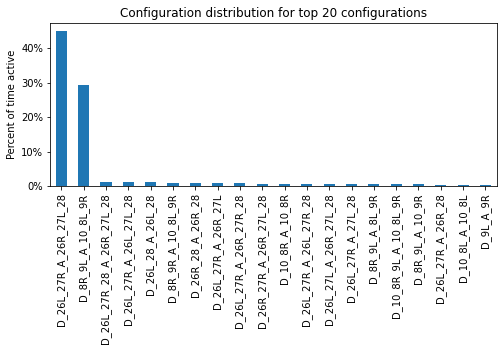

In [26]:
ax = ((config_dist / config_dist.sum()) * 100).head(20).plot(kind="bar", figsize=(8, 3))
ax.set_title("Configuration distribution for top 20 configurations")
ax.set_ylabel("Percent of time active")
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))
plt.show()

- 이러한 접근을 통해 만들 수 있는 가정 하나는 configuration의 분포가 통계적이라는 것 
- 이는 시간이 지남에 따라 변하지 않는다 
- 가정이 맞는지 확인하기 위해 configuration timecourse 사용 

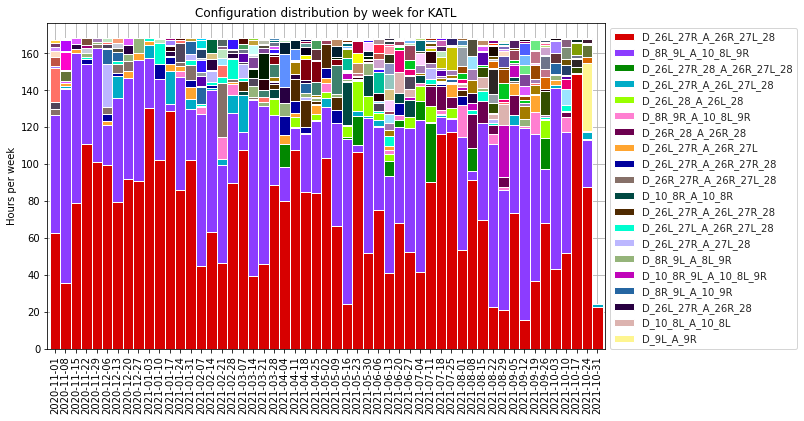

In [27]:
import colorcet as cc
from cycler import cycler

with mpl.rc_context({"axes.prop_cycle": cycler(color=cc.glasbey_bw)}):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_axisbelow(True)
    sns.set_style("whitegrid")
    x = (
        config_timecourse.reset_index()
        .groupby(
            [
                pd.Grouper(key="timestamp", freq="7D", axis=0),
                "airport_config",
            ]
        )
        .size()
        .unstack()
        .fillna(0)
        .astype(int)
    ) / 4
    x.index = x.index.astype(str)
    x[x.sum().sort_values(ascending=False).index].plot(
        kind="bar", stacked=True, width=1, ax=ax
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:20], labels[:20], bbox_to_anchor=(1, 1), loc="upper left")
    ax.set_title(f"Configuration distribution by week for {airport_code.upper()}")
    ax.set_xlabel("")
    ax.set_ylabel("Hours per week")
    plt.show()

- 그래프를 통해 가장 흔한 첫번째, 두번째 configs 가 주기적으로 변하며 week to week 별로 뚜렷한 변화가 있는 것을 알 수 있다 
- 무엇보다도 분포의 전역적인 변화가 없음을 알 수 있다 ( 어느정도의 주기가 있음 )

In [28]:
def make_config_dist(airport_code: str, airport_config_df: pd.DataFrame, normalize: bool = False
) -> pd.Series:
    config_timecourse = (
        airport_config_df.set_index("timestamp")
        .airport_config
        .resample("15min")
        .ffill()
        .dropna()
    )
    config_dist = config_timecourse.value_counts()
    if normalize:
        config_dist /= config_dist.sum()

    # prepend the airport code to the configuration strings
    prefix = pd.Series(f"{airport_code}:", index=config_dist.index)
    config_dist.index = prefix.str.cat(config_dist.index)

    return config_dist

In [29]:
make_config_dist(airport_code, airport_config_df)

katl:D_26L_27R_A_26R_27L_28       15761
katl:D_8R_9L_A_10_8L_9R           10317
katl:D_26L_27R_28_A_26R_27L_28      464
katl:D_26L_27R_A_26L_27L_28         409
katl:D_26L_28_A_26L_28              403
                                  ...  
katl:D_27L_28_A_26R_27L_28            1
katl:D_8R_9L_A_8L                     1
katl:D_8R_9L_A_8R                     1
katl:D_26R_27R_A_27L_28               1
katl:D_8R_A_10_8L                     1
Name: airport_config, Length: 156, dtype: int64

# Censor Data 

- 과거의 Aiport configs 분포를 보고 미래를 예측 
- 하지만 미래를 예측하기 위해 미래의 정보를 사용할 수 없음 -> 시계열 특징 


In [31]:
def censor_data(airport_config_df: pd.DataFrame, timestamp: pd.Timestamp) -> Tuple[str, pd.DataFrame]:
    mask = airport_config_df["timestamp"] <= timestamp #여기서 timestamp는 현재 시간 
    subset = airport_config_df[mask]
    current = subset.iloc[-1].airport_config #해당 timestamp보다 이전의 config들을 가져오고, 마지막 꺼를 return, 마지막꺼 == 현재 configs. 
    return current, subset

In [38]:
#해당 timestamp 이전 시간대의 
timestamp = pd.Timestamp("2020-11-01 05:00:00") 
print(censor_data(airport_config_df, timestamp))

('D_8R_9L_A_10_8L_9R',             timestamp      airport_config
0 2020-11-01 01:11:00  D_8R_9L_A_10_8L_9R
1 2020-11-01 01:57:00  D_8R_9L_A_10_8L_9R
2 2020-11-01 02:53:00  D_8R_9L_A_10_8L_9R
3 2020-11-01 03:54:00  D_8R_9L_A_10_8L_9R
4 2020-11-01 04:52:00  D_8R_9L_A_10_8L_9R)


# Prediction based on Data 

기본 전략으로 세 가지 분포의 가중치 혼합된 예측 분포를 만들 것임 
- 균등 분포 
- 과거 분포 
- 현재 config의 점 질량 

- 사용해오던 예측 프레임을 사용하면서 각각의 분포가 columns으로 되어 있는 데이터 프레임 만들 것임 

- 기르고 각 컬럼들을 합치고 정규화 해서 결과를 만들 것 

In [39]:
#uniform distribution 
predictive_distribution = pd.DataFrame({"uniform": make_uniform(pred_frame)})

first 는 예측하고자 하는 시간과 코드 
- 해당 configuration의 확률을 예측하기 위해선 과거의 데이터를 사용해야 하기 때문에 censor 사용 

In [40]:
first = pred_frame.iloc[0] #<--- 예측하고자 하는 시간과 코드 
airport_code, timestamp, lookahead, _, _ = first
print(f"Airport code: {airport_code}")
print(f"Timestamp: {timestamp}")
print(f"Lookahead: {lookahead}")

Airport code: katl
Timestamp: 2020-11-06 23:00:00
Lookahead: 30


In [43]:
airport_config_df = airport_config_df_map[airport_code]
current, subset = censor_data(airport_config_df, timestamp)
print(f"Current configuration: {current}")

subset.tail()

Current configuration: D_8R_9L_A_10_8L_9R


,timestamp,airport_config
199,2020-11-06 18:53:00,D_8R_9L_A_10_8L_9R
200,2020-11-06 19:53:00,D_8R_9L_A_10_8L_9R
201,2020-11-06 20:54:00,D_8R_9L_A_10_8L_9R
202,2020-11-06 21:54:00,D_8R_9L_A_10_8L_9R
203,2020-11-06 22:54:00,D_8R_9L_A_10_8L_9R


과거 분포 

In [50]:
config_dist = make_config_dist(airport_code, subset, normalize=True) # 해당 subset의 15간격의 분포를 계산해줌
config_dist

katl:D_26L_27R_A_26R_27L_28        0.442681
katl:D_8R_9L_A_10_8L_9R            0.301587
katl:D_8L_9L_A_10_8L_9R            0.102293
katl:D_9L_A_10_9R                  0.035273
katl:D_8R_9L_A_10_8R_9R            0.028219
katl:D_26R_27R_A_26R_27L_28        0.021164
katl:D_8L_9L_A_10_8L_9L            0.021164
katl:D_9L_A_10_8L_9R               0.015873
katl:D_26L_26R_27R_A_26R_27L_28    0.014109
katl:D_26R_27R_A_26R_27R_28        0.010582
katl:D_8L_8R_9L_A_10_8L_9R         0.007055
Name: airport_config, dtype: float64